In [51]:
# Essential imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import tensorflow as tf
from tensorflow import keras
# Python imports

import os
import sys

In [52]:
# Universal path storage as I run both Unix and Windows OS

train_data_path = os.path.join(os.getcwd(), 'data', 'monster_train.csv')
test_data_path = os.path.join(os.getcwd(), 'data', 'monster_comp.csv')
output_template_path = os.path.join(os.getcwd(), 'data', 'sample_sub.csv')
output_dir_path = os.path.join(os.getcwd(), 'output')

# Importing files from these paths

train_data = pd.read_csv(train_data_path, encoding='utf-8')
test_data = pd.read_csv(test_data_path, encoding='utf-8')
output_template_data = pd.read_csv(output_template_path, encoding='utf-8')

In [53]:
# Data Exploration and Preprocessing
train_data.describe()

,id,height,rottingFleshPct,bloodCoverage,aura,hairLength
count,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000
mean,18749.000000,60.479933,20.978922,19.280995,0.197489,3.469250
std,10824.595859,7.755619,10.222874,12.005198,0.084560,0.418789
min,1.000000,22.124607,1.530000,-2.634000,0.020161,1.943124
25%,9375.000000,56.413659,11.540000,8.598000,0.120640,3.186231
50%,18749.000000,62.041574,22.000000,18.667000,0.195185,3.472094
75%,28123.000000,66.017655,29.500000,28.981000,0.250105,3.751260
max,37497.000000,83.070259,48.770000,58.864000,0.540366,5.388365


In [54]:
test_data.describe()

,id,height,rottingFleshPct,bloodCoverage,aura,hairLength
count,12503.000000,12503.000000,12503.000000,12503.000000,12503.000000,12503.000000
mean,6252.000000,60.467536,20.989565,19.345099,0.196484,3.466181
std,3609.449543,7.781946,10.243217,12.072876,0.084802,0.415622
min,1.000000,30.185898,3.040000,0.001000,0.034989,2.029264
25%,3126.500000,56.236763,11.620000,8.688000,0.119637,3.184046
50%,6252.000000,62.033627,22.030000,18.761000,0.193852,3.464309
75%,9377.500000,66.059464,29.640000,29.268000,0.249669,3.748283
max,12503.000000,83.321551,46.610000,59.504000,0.496031,5.159501


In [55]:
# Getting column datatypes
one_hot = pd.get_dummies(train_data['color'], dtype=int, drop_first=False)
# drop categorical columns (class is a target)
train_data = train_data.drop('color', axis=1)
# append encoded
train_data = train_data.join(one_hot)
train_data

one_hot_test = pd.get_dummies(test_data['color'], dtype=int, drop_first=False)
# drop categorical for test
test_data.drop('color', axis=1, inplace=True)
test_data = test_data.join(one_hot_test)


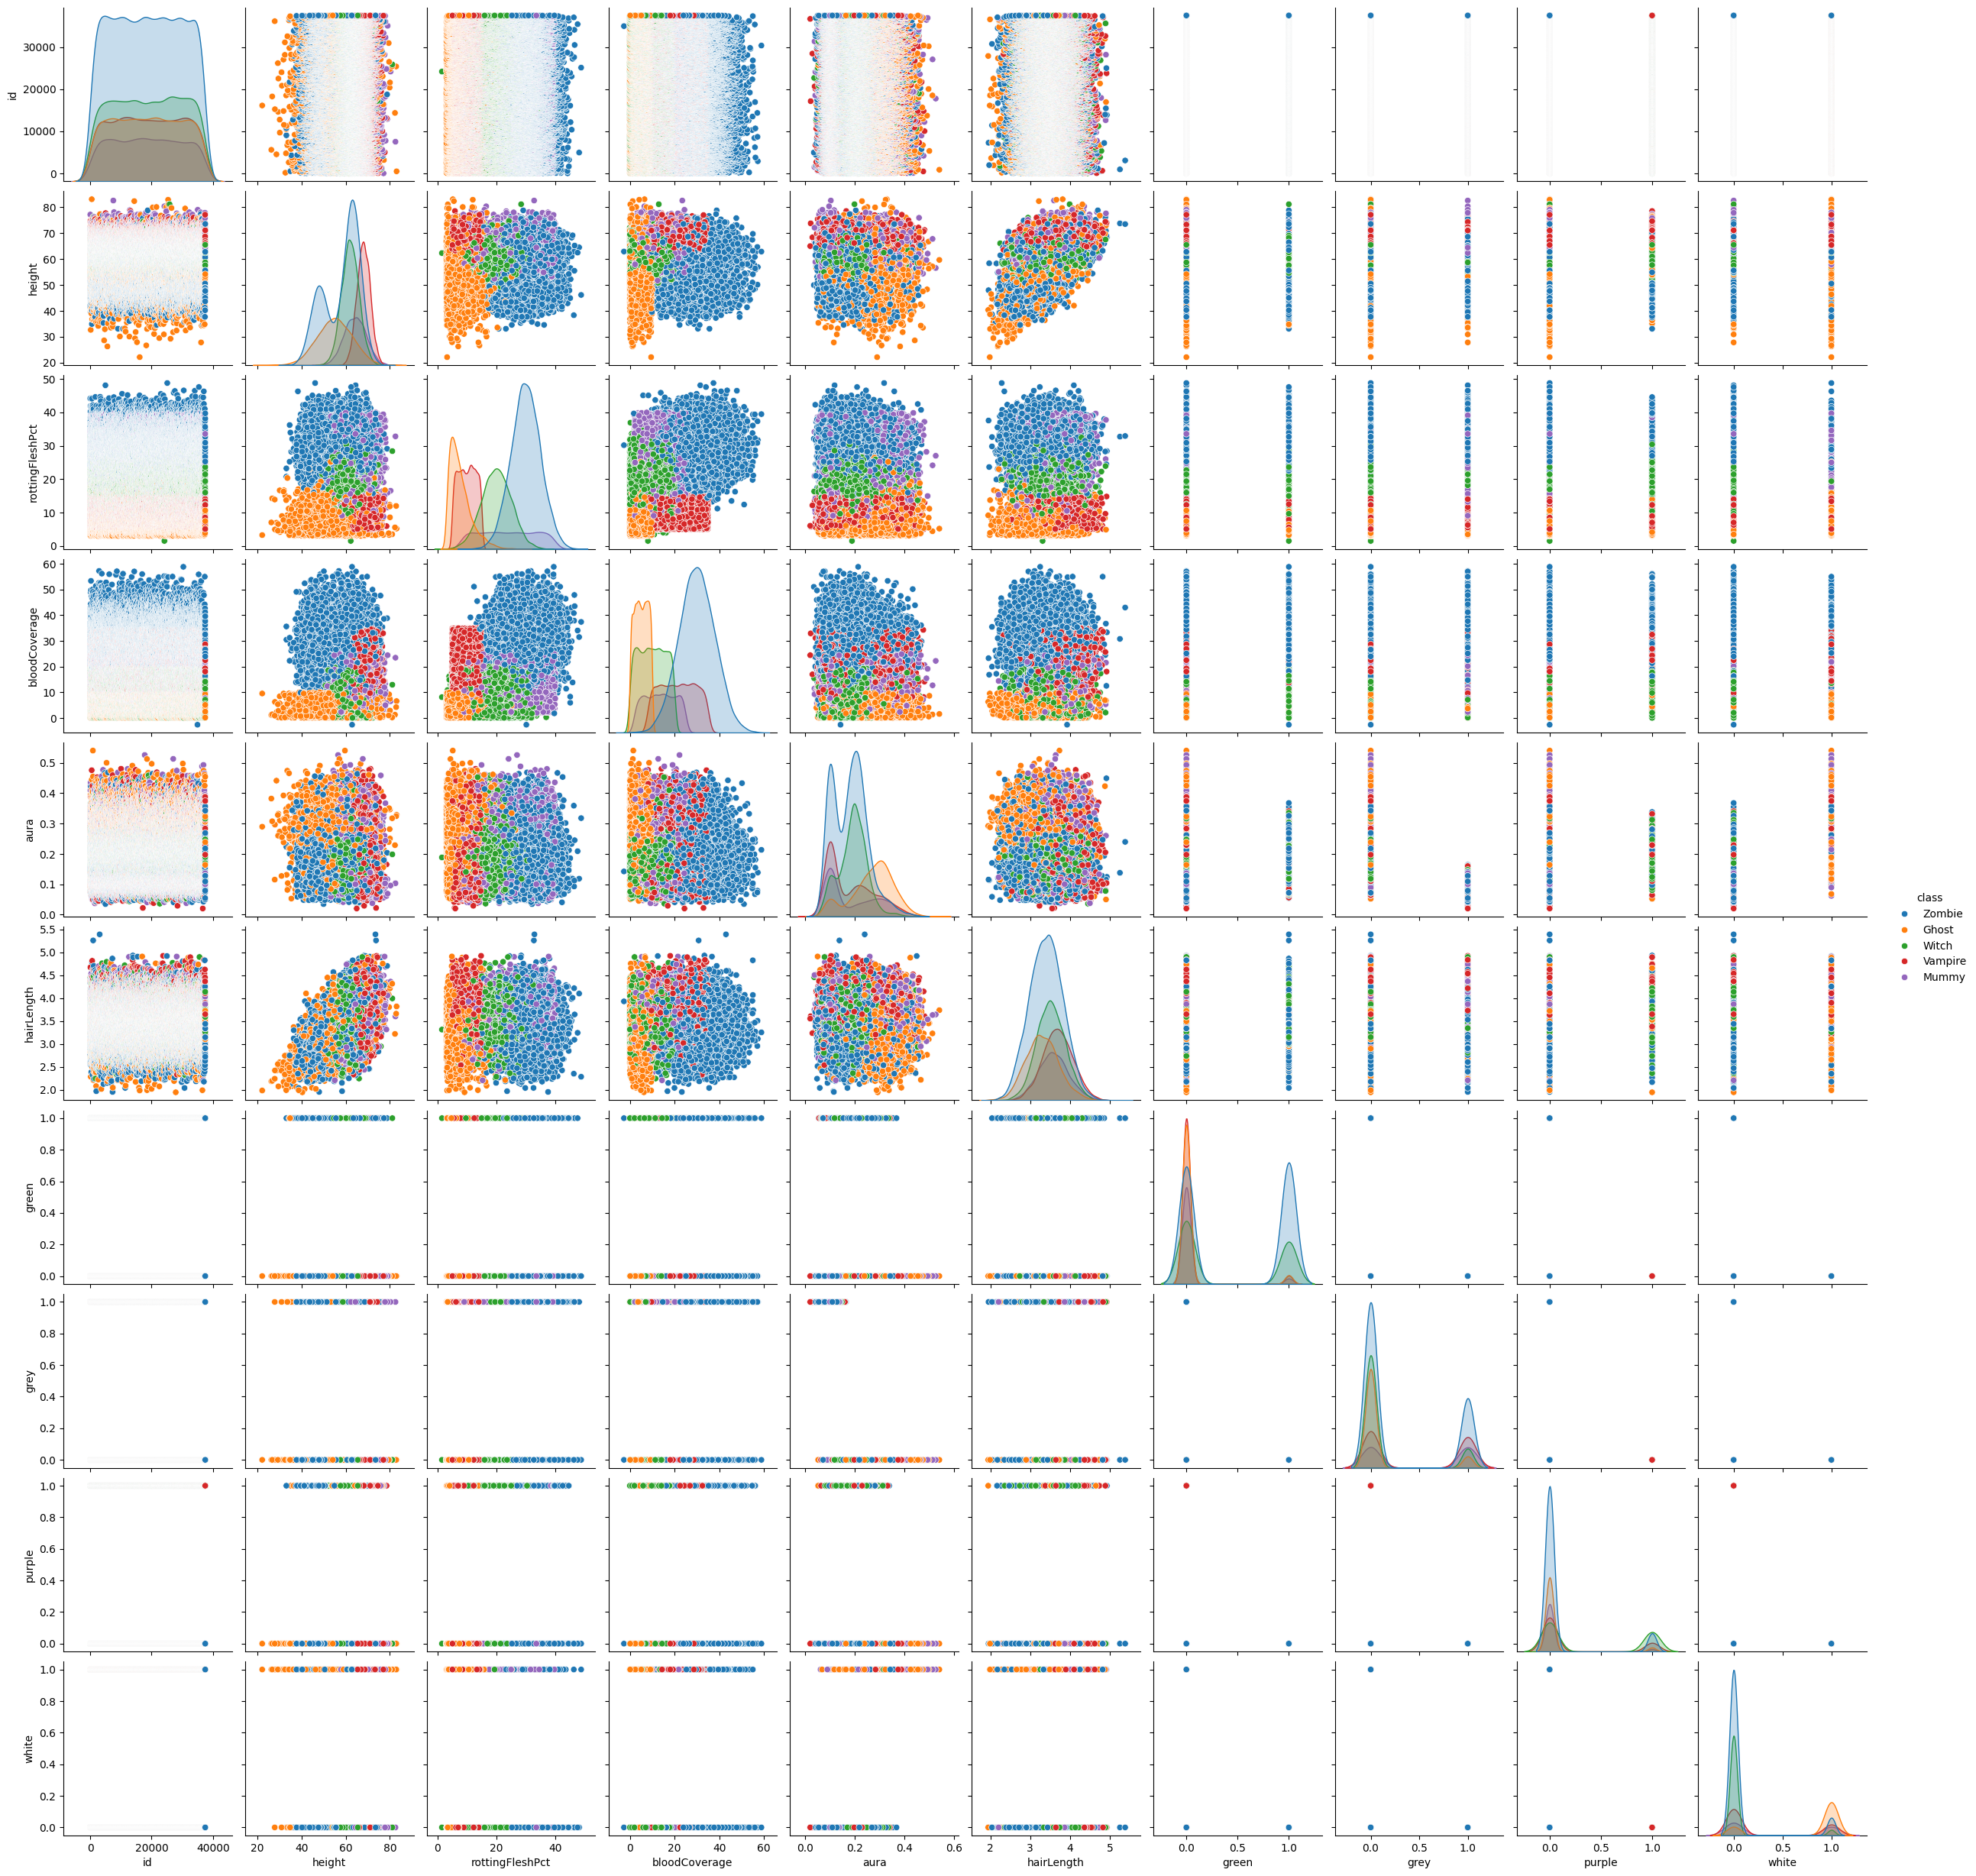

In [56]:
# check for collinear features
sns.pairplot(train_data, hue='class')


In [57]:
# Add metafeatures composed of well-clustered columns
# Pairs: bloodCoverage and rottingFleshPct, bloodCoverage and height, hairLength and rottingFleshPct, bloodCoverage and hairLength, aura and bloodCoverage
# train_data["bloodFlesh"] = train_data["bloodCoverage"] * train_data["rottingFleshPct"]
train_data["bloodHair"] = train_data["bloodCoverage"] * train_data["hairLength"]
train_data["bloodAura"] = train_data["bloodCoverage"] * train_data["aura"]
train_data["hairFlesh"] = train_data["hairLength"] * train_data["rottingFleshPct"]
train_data["hairHeight"] = train_data["hairLength"] * train_data["height"]

# Now the same for test data
# test_data["bloodFlesh"] = test_data["bloodCoverage"] * test_data["rottingFleshPct"]
test_data["bloodHair"] = test_data["bloodCoverage"] * test_data["hairLength"]
test_data["bloodAura"] = test_data["bloodCoverage"] * test_data["aura"]
test_data["hairFlesh"] = test_data["hairLength"] * test_data["rottingFleshPct"]
test_data["hairHeight"] = test_data["hairLength"] * test_data["height"]


test_id = test_data['id']
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)
train_data.drop('bloodCoverage', axis=1, inplace=True)
test_data.drop('bloodCoverage', axis=1, inplace=True)

In [58]:
# split into validation and training datasets
train, val = train_test_split(train_data, test_size=0.2, shuffle=True, random_state=42)
train_X, val_X = train.drop('class', axis=1), val.drop('class', axis=1)
# label encoding
le1, le2 = LabelEncoder(), LabelEncoder()
train_y, val_y = le1.fit_transform(train["class"].values), le2.fit_transform(val["class"].values)
X_test = test_data


In [59]:
clf = RandomForestClassifier(n_estimators=200).fit(train_X, train_y)
indices = np.argsort(clf.feature_importances_)[::-1]
print('Feature Ranking:')
for f in range(train_X.shape[1]):
    print('{}. feature {} {} ({})'.format(f+1, indices[f], train_X.columns[indices[f]], clf.feature_importances_[indices[f]]))


Feature Ranking:
1. feature 1 rottingFleshPct (0.21449072495501598)
2. feature 8 bloodHair (0.2052381608065285)
3. feature 10 hairFlesh (0.1666637844835572)
4. feature 9 bloodAura (0.09954278897943182)
5. feature 0 height (0.0951759153024754)
6. feature 11 hairHeight (0.051626463207747435)
7. feature 2 aura (0.04614192200324411)
8. feature 7 white (0.044043389963597725)
9. feature 3 hairLength (0.03137704171439353)
10. feature 4 green (0.017954441645821335)
11. feature 5 grey (0.015920779913067847)
12. feature 6 purple (0.011824587025119184)


In [60]:
# check p-value significance
est = sm.OLS(train_y, train_X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     6852.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:43:40   Log-Likelihood:                -35148.
No. Observations:               29997   AIC:                         7.032e+04
Df Residuals:                   29985   BIC:                         7.042e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
height              0.0501      0.004     

In [93]:
# scaling
s1, s2 = StandardScaler(), StandardScaler()
train_X, val_X = s1.fit_transform(train_X, train_y), s2.fit_transform(val_X, val_y)
test_data = s2.fit_transform(test_data)

In [96]:
# Ensemble creation for classifiers and experimentation
# Create deep learning model with layers for classification
input_shape = train_X.shape[1]  # Adjust this to match your input features
num_classes = len(np.unique(train_y))
num_epochs = 1000  # Adjust the number of epochs
batch_size = 64  # Adjust the batch size

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,  # Adjust the initial learning rate
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    keras.layers.BatchNormalization(),  
    keras.layers.Dense(128, activation='swish'),
    keras.layers.BatchNormalization(),  
    keras.layers.Dropout(0.2),  # Add dropout layer
    keras.layers.Dense(num_classes, activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=50,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restores the best model weights found during training
)

# Compile the Model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the Model
loss, accuracy = model.evaluate(val_X, val_y)
print(f'Validation accuracy: {accuracy}')

# Make Predictions
predictions = model.predict(X_test)


Epoch 1/1000
469/469 [==============================] - 2s 2ms/step - loss: 0.4147 - accuracy: 0.8518 - val_loss: 0.3348 - val_accuracy: 0.8709
Epoch 2/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3707 - accuracy: 0.8637 - val_loss: 0.3703 - val_accuracy: 0.8603
Epoch 3/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3620 - accuracy: 0.8675 - val_loss: 0.3536 - val_accuracy: 0.8812
Epoch 4/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3661 - accuracy: 0.8679 - val_loss: 0.3055 - val_accuracy: 0.8825
Epoch 5/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3509 - accuracy: 0.8729 - val_loss: 0.3481 - val_accuracy: 0.8749
Epoch 6/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3583 - accuracy: 0.8691 - val_loss: 0.3089 - val_accuracy: 0.8781
Epoch 7/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.3495 - accuracy: 0.8731 - val_loss: 0.3222 - val_accuracy:

In [97]:
# Cross validation
num_folds = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store the results from each fold
fold_accuracies = []

for fold, (train_indices, val_indices) in enumerate(skf.split(train_X, train_y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets
    fold_train_X, fold_val_X = train_X[train_indices], train_X[val_indices]
    fold_train_y, fold_val_y = train_y[train_indices], train_y[val_indices]

    # Create a new model for each fold (optional)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Adjust the initial learning rate
    decay_steps=10000,
    decay_rate=0.9
)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # model = keras.Sequential([
    #     keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    #     keras.layers.BatchNormalization(),  
    #     keras.layers.Dense(128, activation='swish'),
    #     keras.layers.BatchNormalization(),  
    #     keras.layers.Dropout(0.2),  # Add dropout layer
    #     keras.layers.Dense(num_classes, activation='softmax')
    # ])

    # use model already defined before

    # early_stopping = keras.callbacks.EarlyStopping(
    #     monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    #     patience=50,          # Number of epochs with no improvement after which training will stop
    #     restore_best_weights=True  # Restores the best model weights found during training
    # )

    # Compile the Model
    # model.compile(optimizer=optimizer, 
    #             loss='sparse_categorical_crossentropy', 
    #             metrics=['accuracy'])

    # Train the Model
    history = model.fit(fold_train_X, fold_train_y, validation_data=(fold_val_X, fold_val_y), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Evaluate the model on the validation data for this fold
    _, accuracy = model.evaluate(fold_val_X, fold_val_y)
    fold_accuracies.append(accuracy)

# Calculate the mean and standard deviation of accuracies across folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation: {std_accuracy}")

Fold 1/5


Epoch 1/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2748 - accuracy: 0.8932 - val_loss: 0.2444 - val_accuracy: 0.9013
Epoch 2/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2740 - accuracy: 0.8917 - val_loss: 0.2479 - val_accuracy: 0.8982
Epoch 3/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2724 - accuracy: 0.8939 - val_loss: 0.2539 - val_accuracy: 0.8967
Epoch 4/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2740 - accuracy: 0.8937 - val_loss: 0.2522 - val_accuracy: 0.8967
Epoch 5/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2707 - accuracy: 0.8935 - val_loss: 0.2498 - val_accuracy: 0.8950
Epoch 6/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2736 - accuracy: 0.8937 - val_loss: 0.2538 - val_accuracy: 0.8997
Epoch 7/1000
375/375 [==============================] - 1s 2ms/step - loss: 0.2708 - accuracy: 0.8946 - val_loss: 0.2598 - val_accuracy:

In [95]:
# Submission of model predictions
# Make predictions on the test data
test_predictions = model.predict(X_test)
# Convert the predicted probabilities to class labels
predicted_classes = np.argmax(test_predictions, axis=1)
# Map class labels back to the original class names using LabelEncoder
predicted_class_names = le2.inverse_transform(predicted_classes)
# Convert to string
predicted_class_names = predicted_class_names.astype(str)

# Create a DataFrame with 'id' and 'class' columns
submission_df = pd.DataFrame({'id': test_id, 'class': predicted_class_names})

# Save the DataFrame to a CSV file
submission_path = os.path.join(output_dir_path, 'submission.csv')
submission_df.to_csv(submission_path, index=False)

print(f'Submission saved to {submission_path}')


391/391 [==============================] - 0s 846us/step
Submission saved to c:\Users\atulp\Documents\VSC\ML-and-AI-Projects\Halloween-Monster-Classification\output\submission.csv


In [83]:
print(submission_df)

          id  class
0          1  Mummy
1          2  Witch
2          3  Mummy
3          4  Ghost
4          5  Ghost
...      ...    ...
12498  12499  Mummy
12499  12500  Ghost
12500  12501  Mummy
12501  12502  Ghost
12502  12503  Witch

[12503 rows x 2 columns]
